In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [4]:
# Get data into dataframe
df = pd.read_csv('../WMA_fractions_v2.csv', skiprows=1)
df = df[['Conservative_Temperature_[deg_C]', 'Absolute_Salinity_[PSU]', 'Dissolved_Oxygen_[micro_mol_per_kg]','Depth_[m]', 'Latitude_[deg_N]', 'Longitude_[deg_E]', 'Datetime_[UTC]']]
df = df.dropna()

In [5]:
# Break down datetime into separate columns
df['Datetime_[UTC]'] = pd.to_datetime(df['Datetime_[UTC]'])
df['Year'] = df['Datetime_[UTC]'].dt.year
df['Month'] = df['Datetime_[UTC]'].dt.month
df['Day'] = df['Datetime_[UTC]'].dt.day
df = df.drop(columns=['Datetime_[UTC]'])

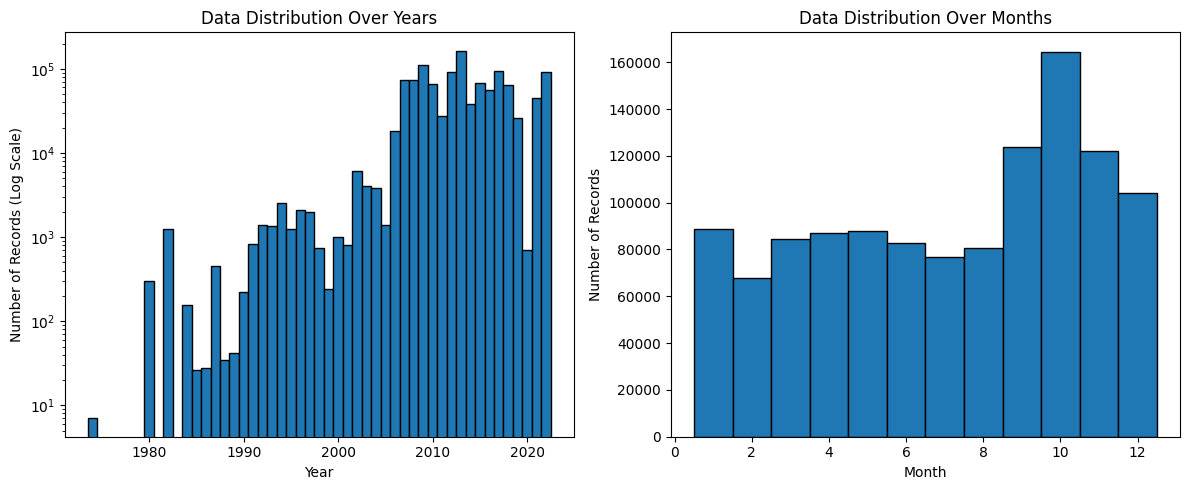

In [13]:
# Make histogram of data distribution over years and months

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.hist(df['Year'], bins=np.arange(df['Year'].min(), df['Year'].max()+1)-0.5, edgecolor='black', log=True)
plt.title('Data Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Records (Log Scale)')

plt.subplot(1, 2, 2)
plt.hist(df['Month'], bins=np.arange(1, 14)-0.5, edgecolor='black')
plt.title('Data Distribution Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Records')

plt.tight_layout()
plt.show()

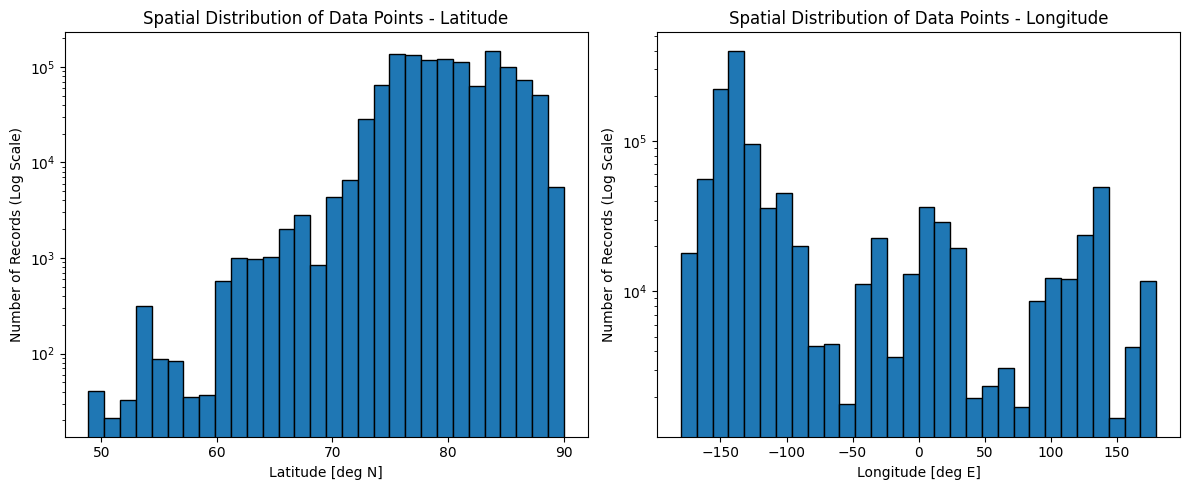

In [66]:
# Histogram of spatial distribution of data points
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df['Latitude_[deg_N]'], bins=30, edgecolor='black', log=True)
plt.title('Spatial Distribution of Data Points - Latitude')
plt.xlabel('Latitude [deg N]')
plt.ylabel('Number of Records (Log Scale)')
plt.subplot(1, 2, 2)
plt.hist(df['Longitude_[deg_E]'], bins=30, edgecolor='black', log=True)
plt.title('Spatial Distribution of Data Points - Longitude')
plt.xlabel('Longitude [deg E]') 
plt.ylabel('Number of Records (Log Scale)')
plt.tight_layout()
plt.show()

In [27]:
# Peisong code altered
def profileNo_vs_latlon_bins(
    df: pd.DataFrame,
    lat_step: float,
    lon_step: float,
    show_threshold: bool = False,
    threshold_quantile: float = 0.95
) -> None:
    """
    Plot the number of profiles in each latitude-longitude bin.

    Args:
        ds (pd.DataFrame): The dataset to plot.
        lat_step (float): The latitude step size for binning.
        lon_step (float): The longitude step size for binning.
        show_threshold (bool, optional): Whether to show the threshold marker. Defaults to False.
        threshold_quantile (float, optional): The quantile value for threshold calculation. Defaults to 0.95.

    Returns:
        None
    """

    lon_bins = pd.cut(df['Longitude_[deg_E]'], bins=np.arange(-180, 185, lon_step))
    lat_bins = pd.cut(df['Latitude_[deg_N]'], bins=np.arange(-90, 95, lat_step))

    latlon_groups = df.groupby([lon_bins, lat_bins])

    g_len = []
    for group_key in latlon_groups.groups:
        try:
            group = latlon_groups.get_group(group_key)
            # print(f"Group {group_key}: {len(group)} rows")
            g_len.append(len(group))
        except KeyError:
            # Handle the KeyError gracefully
            print(f"No data points for group {group_key}")

    g_len_sorted = sorted(g_len)
    transition_point = None

    g_len_diff = np.diff(g_len_sorted)

    threshold = np.quantile(g_len_diff, threshold_quantile)  # set a threshold for the difference between adjacent elements

    for i in range(1, len(g_len_sorted)):
        if g_len_sorted[i] - g_len_sorted[i-1] > threshold:
            transition_point = i - 1
            break

    trace = go.Scatter(
        x=list(range(len(g_len_sorted))),
        y=g_len_sorted
    )

    if show_threshold:
        if transition_point is not None:
            red_dot = go.Scatter(
                x=[transition_point],
                y=[g_len_sorted[transition_point]],
                mode='markers',
                marker=dict(color='red', size=10)
            )
            fig_data = [trace, red_dot]
        else:
            fig_data = [trace]
    else:
        fig_data = [trace]

    layout = go.Layout(
        xaxis=dict(title='Bin No.'),
        yaxis=dict(title='Number of profiles')
    )

    fig = go.Figure(data=fig_data, layout=layout)
    fig.show()

In [28]:
profileNo_vs_latlon_bins(df, lat_step=5, lon_step=5, show_threshold=True, threshold_quantile=0.95)

/var/folders/v0/0lp_zzrd33sgh7y2jyh9zzdm0000gn/T/ipykernel_49744/3175070231.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latlon_groups = df.groupby([lon_bins, lat_bins])


In [67]:
from mpl_toolkits.basemap import Basemap

def plot_heatmap(ds_cleaned, bin_max=None):
    '''
    ds_cleaned: A dataset containing cleaned data.
    bin_max (optional): The maximum bin value for the heatmap. If not provided, it is calculated as the maximum value of the histogram.
    '''

    # Define the map bounds and resolution
    lon_min, lon_max = -180, 180
    lat_min, lat_max = 45, 90
    latlon_step = 5
    resolution = 'l'  # l for low resolution, h for high resolution

    # Define bin edges for longitude, latitude, and pressure
    lon_bins = np.arange(lon_min, lon_max+1, latlon_step)
    lat_bins = np.arange(lat_min, lat_max+1, latlon_step)

    # Use the number of profiles in each bin as the height
    H, xedges, yedges = np.histogram2d(ds_cleaned['Longitude_[deg_E]'], ds_cleaned['Latitude_[deg_N]'], bins=[lon_bins, lat_bins])

    # Set up the figure and the Basemap instance
    fig = plt.figure(figsize=(8,8),dpi=300)
    m = Basemap(projection='npstere', boundinglat=lat_min, lon_0=0, resolution=resolution)

    m.drawparallels(np.arange(lat_min, lat_max+1, 5), labels=[], linewidth=0.1)
    m.drawmeridians(np.arange(lon_min, lon_max+1, 5), labels=[], linewidth=0.1)

    # Create the X and Y grids for the histogram
    X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

    new_col = np.arange(lat_min, lat_max, latlon_step)
    Y = np.concatenate((Y, new_col[:, np.newaxis]), axis=1)

    new_col = lon_max*np.ones(len(lat_bins)-1)
    X = np.concatenate((X, new_col[:, np.newaxis]), axis=1)

    new_row = X[-1]
    X=np.vstack([X,new_row])

    new_row = lat_max*np.ones(np.shape(Y)[1])
    Y=np.vstack([Y,new_row])

    # Create the colored grid using pcolormesh
    cmap = plt.get_cmap('Wistia').copy()
    cmap.set_under(color='white', alpha=1.0)
    cmap.set_over(color='white', alpha=1.0)

    if bin_max is None:
        bin_max = H.max()
    

    m.pcolormesh(X, Y, H.T, cmap=cmap, vmin=1, vmax=bin_max, latlon=True)

    m.drawcoastlines()
    m.fillcontinents(color='grey',lake_color='lightblue')

    # Add a colorbar
    cbar = m.colorbar(location='bottom', pad="5%")
    cbar.set_label('Number of profiles')

    # Set the axis labels and title
    plt.xticks([])
    plt.yticks([])
    plt.title('Profiles distribution')

    # Show the plot
    plt.show()
    print(f'bin max={bin_max}')

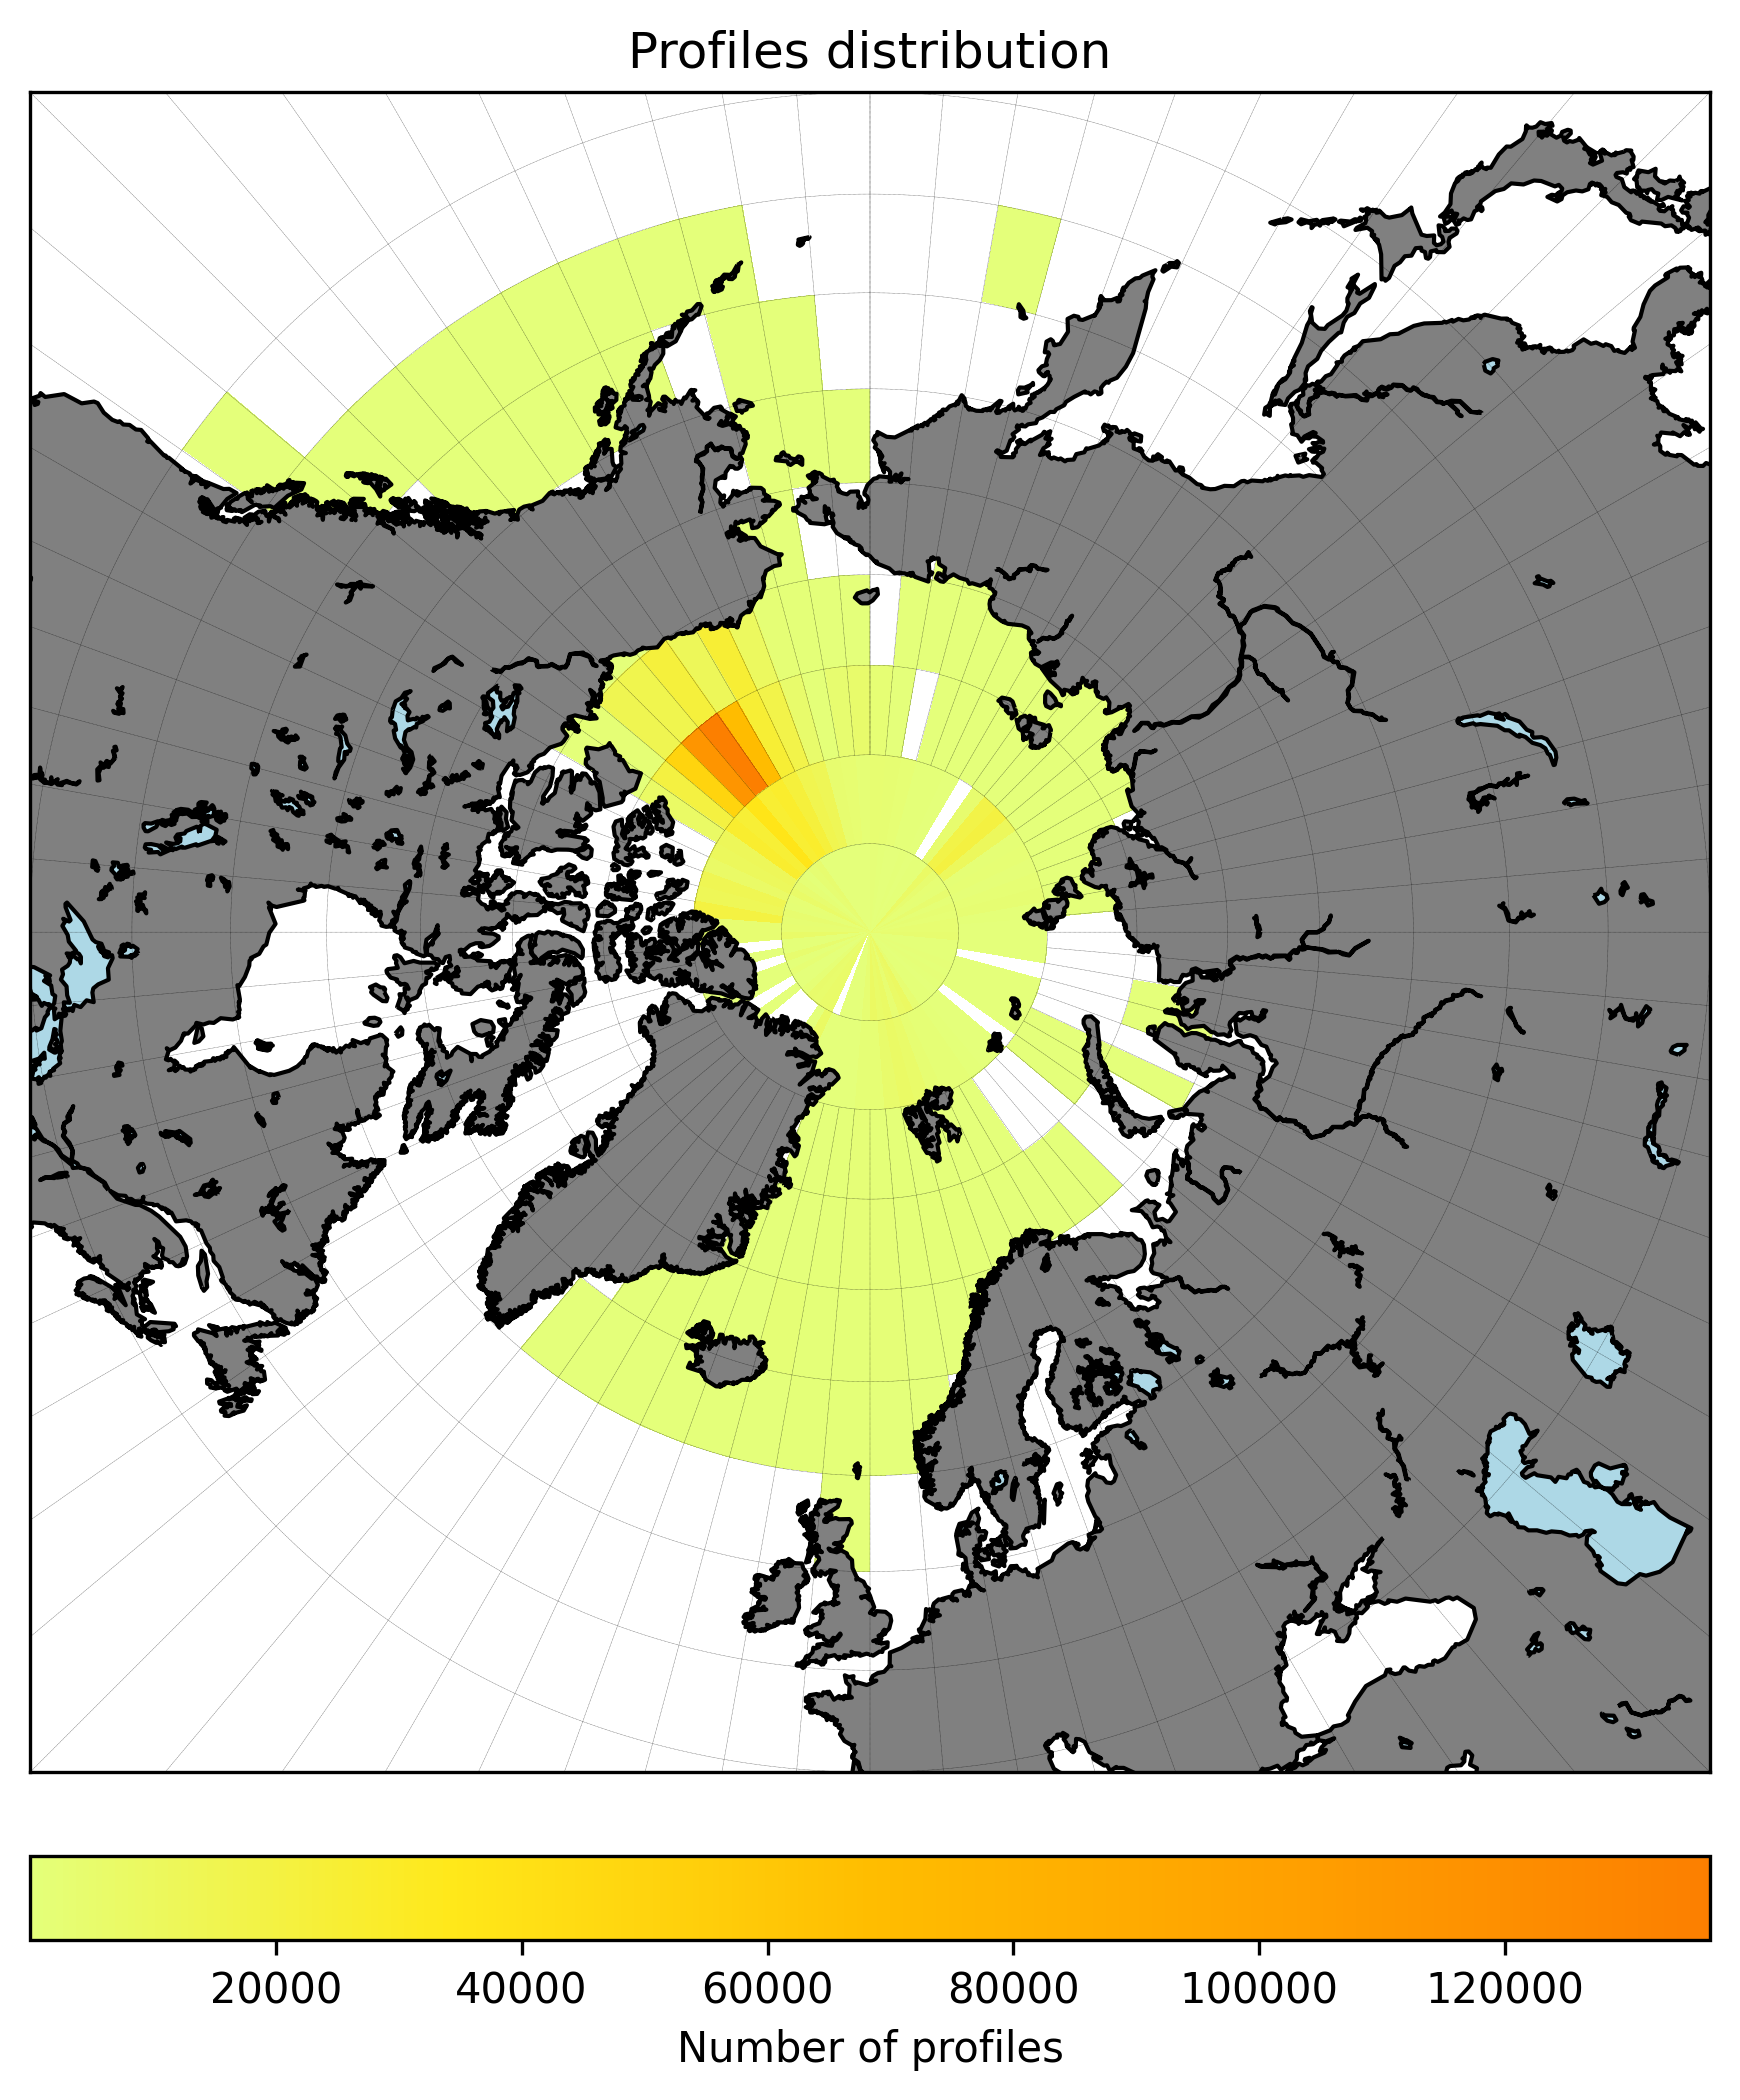

bin max=136672.0


In [68]:
plot_heatmap(df)